<a href="https://colab.research.google.com/github/y-oth/dst_assessment2/blob/main/GradCAM_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

TO DO THIS, GO ON KAGGLE :https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri

THEN DOWLOAD TO ZIP USINNG THE DOWLOAD BUTTON.

THEN ADD IT TO YOUR GOOGLE DRIVE AS A ZIP FILE.
THEN MYDIRVE/YOUR_NOTEBOOK/DATASET.ZIP


In [ ]:
!unzip "/content/drive/MyDrive/Github/DST/archive.zip" -d "/content/data"



Archive:  /content/drive/MyDrive/Github/Assessment 2/MRI Brain Data.zip
  inflating: /content/data/Testing/glioma_tumor/image(1).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(10).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(100).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(11).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(12).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(13).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(14).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(15).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(16).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(17).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(18).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(19).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(2).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(20).jpg  
  inflating: /content/data/Testin

In [4]:
!ls /content/data


Testing  Training


Loaded image: /content/data/Training/pituitary_tumor/p (30).jpg


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

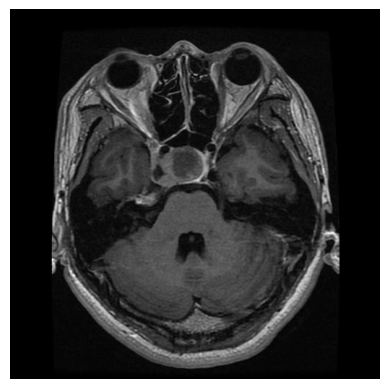

In [5]:
import os
from PIL import Image
import matplotlib.pyplot as plt

root = "/content/data/Training"

# Find the first image in the training folder
image_path = None
for subdir, dirs, files in os.walk(root):
    for file in files:
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            image_path = os.path.join(subdir, file)
            break
    if image_path:
        break

print("Loaded image:", image_path)

img = Image.open(image_path)
plt.imshow(img)
plt.axis("off")


In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder("/content/data/Training", transform=transform)
test_dataset  = datasets.ImageFolder("/content/data/Testing",  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [7]:
train_dataset.classes


['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [8]:
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)


torch.Size([32, 3, 224, 224]) torch.Size([32])


(np.float64(-0.5), np.float64(1809.5), np.float64(453.5), np.float64(-0.5))

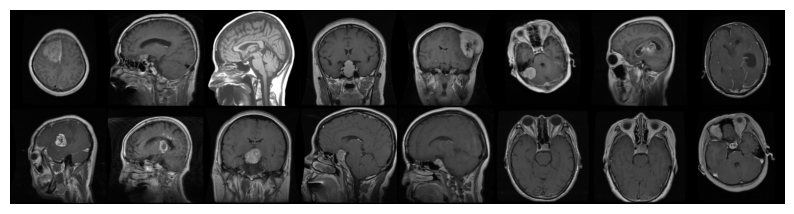

In [9]:
import matplotlib.pyplot as plt
import torchvision

plt.figure(figsize=(10,10))
plt.imshow(torchvision.utils.make_grid(images[:16]).permute(1,2,0))
plt.axis("off")


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GradCAM_CNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        # ---- 1st conv block ----
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)   # 256 → 128

        # ---- 2nd conv block ----
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)   # 128 → 64

        # ---- 3rd conv block (last conv, used for GradCAM) ----
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)   # 64 → 32

        # ---- Fully connected classifier ----
        self.fc1 = nn.Linear(128 * 28 * 28, 128)

        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        self.feature_maps = x            # store for GradCAM
        x = self.pool3(x)

        x = x.view(x.size(0), -1)        # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GradCAM_CNN(num_classes=len(train_dataset.classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [12]:
import json
import time
import os
import torch
import torch.nn as nn


# Helper: Count parameters
def count_params(model):
    return sum(p.numel() for p in model.parameters())


# Checkpoint directory
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

best_val_loss = float("inf")
best_model_path = os.path.join(checkpoint_dir, "best_model.pth")


# Track metrics for JSON output
history = {
    "training_loss": [],
    "training_accuracy": [],
    "validation_loss": [],
    "validation_accuracy": []
}


# Training loop
EPOCHS = 50
start_time = time.time()

for epoch in range(EPOCHS):

    # TRAINING
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    #VALIDATION
    model.eval()
    val_loss_running = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss_running += loss.item()
            _, preds = outputs.max(1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_loss = val_loss_running / len(test_loader)
    val_acc = val_correct / val_total

    # Save metrics
    history["training_loss"].append(train_loss)
    history["training_accuracy"].append(train_acc)
    history["validation_loss"].append(val_loss)
    history["validation_accuracy"].append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

    # ===== Checkpoint: Save best model =====
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved better model → {best_model_path}")


# Training completed

end_time = time.time()
training_time = end_time - start_time


model.eval()
test_loss_running = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss_running += loss.item()
        _, preds = outputs.max(1)
        test_total += labels.size(0)
        test_correct += (preds == labels).sum().item()

test_loss = test_loss_running / len(test_loader)
test_acc = test_correct / test_total



# Build JSON results dictionary
results = {
    "training_loss": history["training_loss"],
    "training_accuracy": history["training_accuracy"],
    "validation_loss": history["validation_loss"],
    "validation_accuracy": history["validation_accuracy"],
    "training_time_seconds": training_time,
    "model_params": {
        "num_conv_layers": 3,
        "filter_base": 32,
        "dense_units": 128,
        "IMG_SIZE": 256,
        "num_classes": len(train_dataset.classes),
        "total_parameters": count_params(model)
    },
    "test_loss": test_loss,
    "test_accuracy": test_acc
}

# Save JSON
with open("model_training_results.json", "w") as f:
    json.dump(results, f, indent=4)

print(f"\nFINAL TEST RESULTS → Loss: {test_loss:.4f},  Accuracy: {test_acc:.4f}")
print("Training results saved to model_training_results.json")


Epoch [1/50] Train Loss: 0.9780 | Train Acc: 58.54% | Val Loss: 2.0071 | Val Acc: 36.55%
Saved better model → checkpoints/best_model.pth
Epoch [2/50] Train Loss: 0.6597 | Train Acc: 72.06% | Val Loss: 2.2627 | Val Acc: 42.89%
Epoch [3/50] Train Loss: 0.5284 | Train Acc: 79.16% | Val Loss: 2.7998 | Val Acc: 40.10%
Epoch [4/50] Train Loss: 0.4638 | Train Acc: 81.43% | Val Loss: 2.6404 | Val Acc: 50.51%
Epoch [5/50] Train Loss: 0.3771 | Train Acc: 85.89% | Val Loss: 2.7653 | Val Acc: 56.60%
Epoch [6/50] Train Loss: 0.2990 | Train Acc: 89.13% | Val Loss: 2.9618 | Val Acc: 62.44%
Epoch [7/50] Train Loss: 0.2542 | Train Acc: 90.84% | Val Loss: 2.6913 | Val Acc: 67.77%
Epoch [8/50] Train Loss: 0.1934 | Train Acc: 93.59% | Val Loss: 3.6342 | Val Acc: 64.21%
Epoch [9/50] Train Loss: 0.1810 | Train Acc: 93.69% | Val Loss: 3.4331 | Val Acc: 72.59%
Epoch [10/50] Train Loss: 0.1295 | Train Acc: 96.17% | Val Loss: 3.7198 | Val Acc: 68.02%
Epoch [11/50] Train Loss: 0.0950 | Train Acc: 97.14% | Val Lo

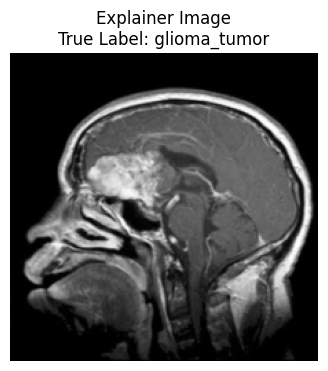

Image dimensions: torch.Size([3, 224, 224])
Predicted Label: no_tumor


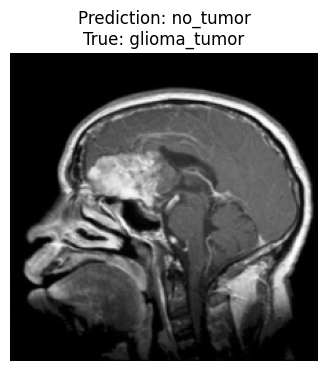

Feature map size: torch.Size([128, 56, 56])


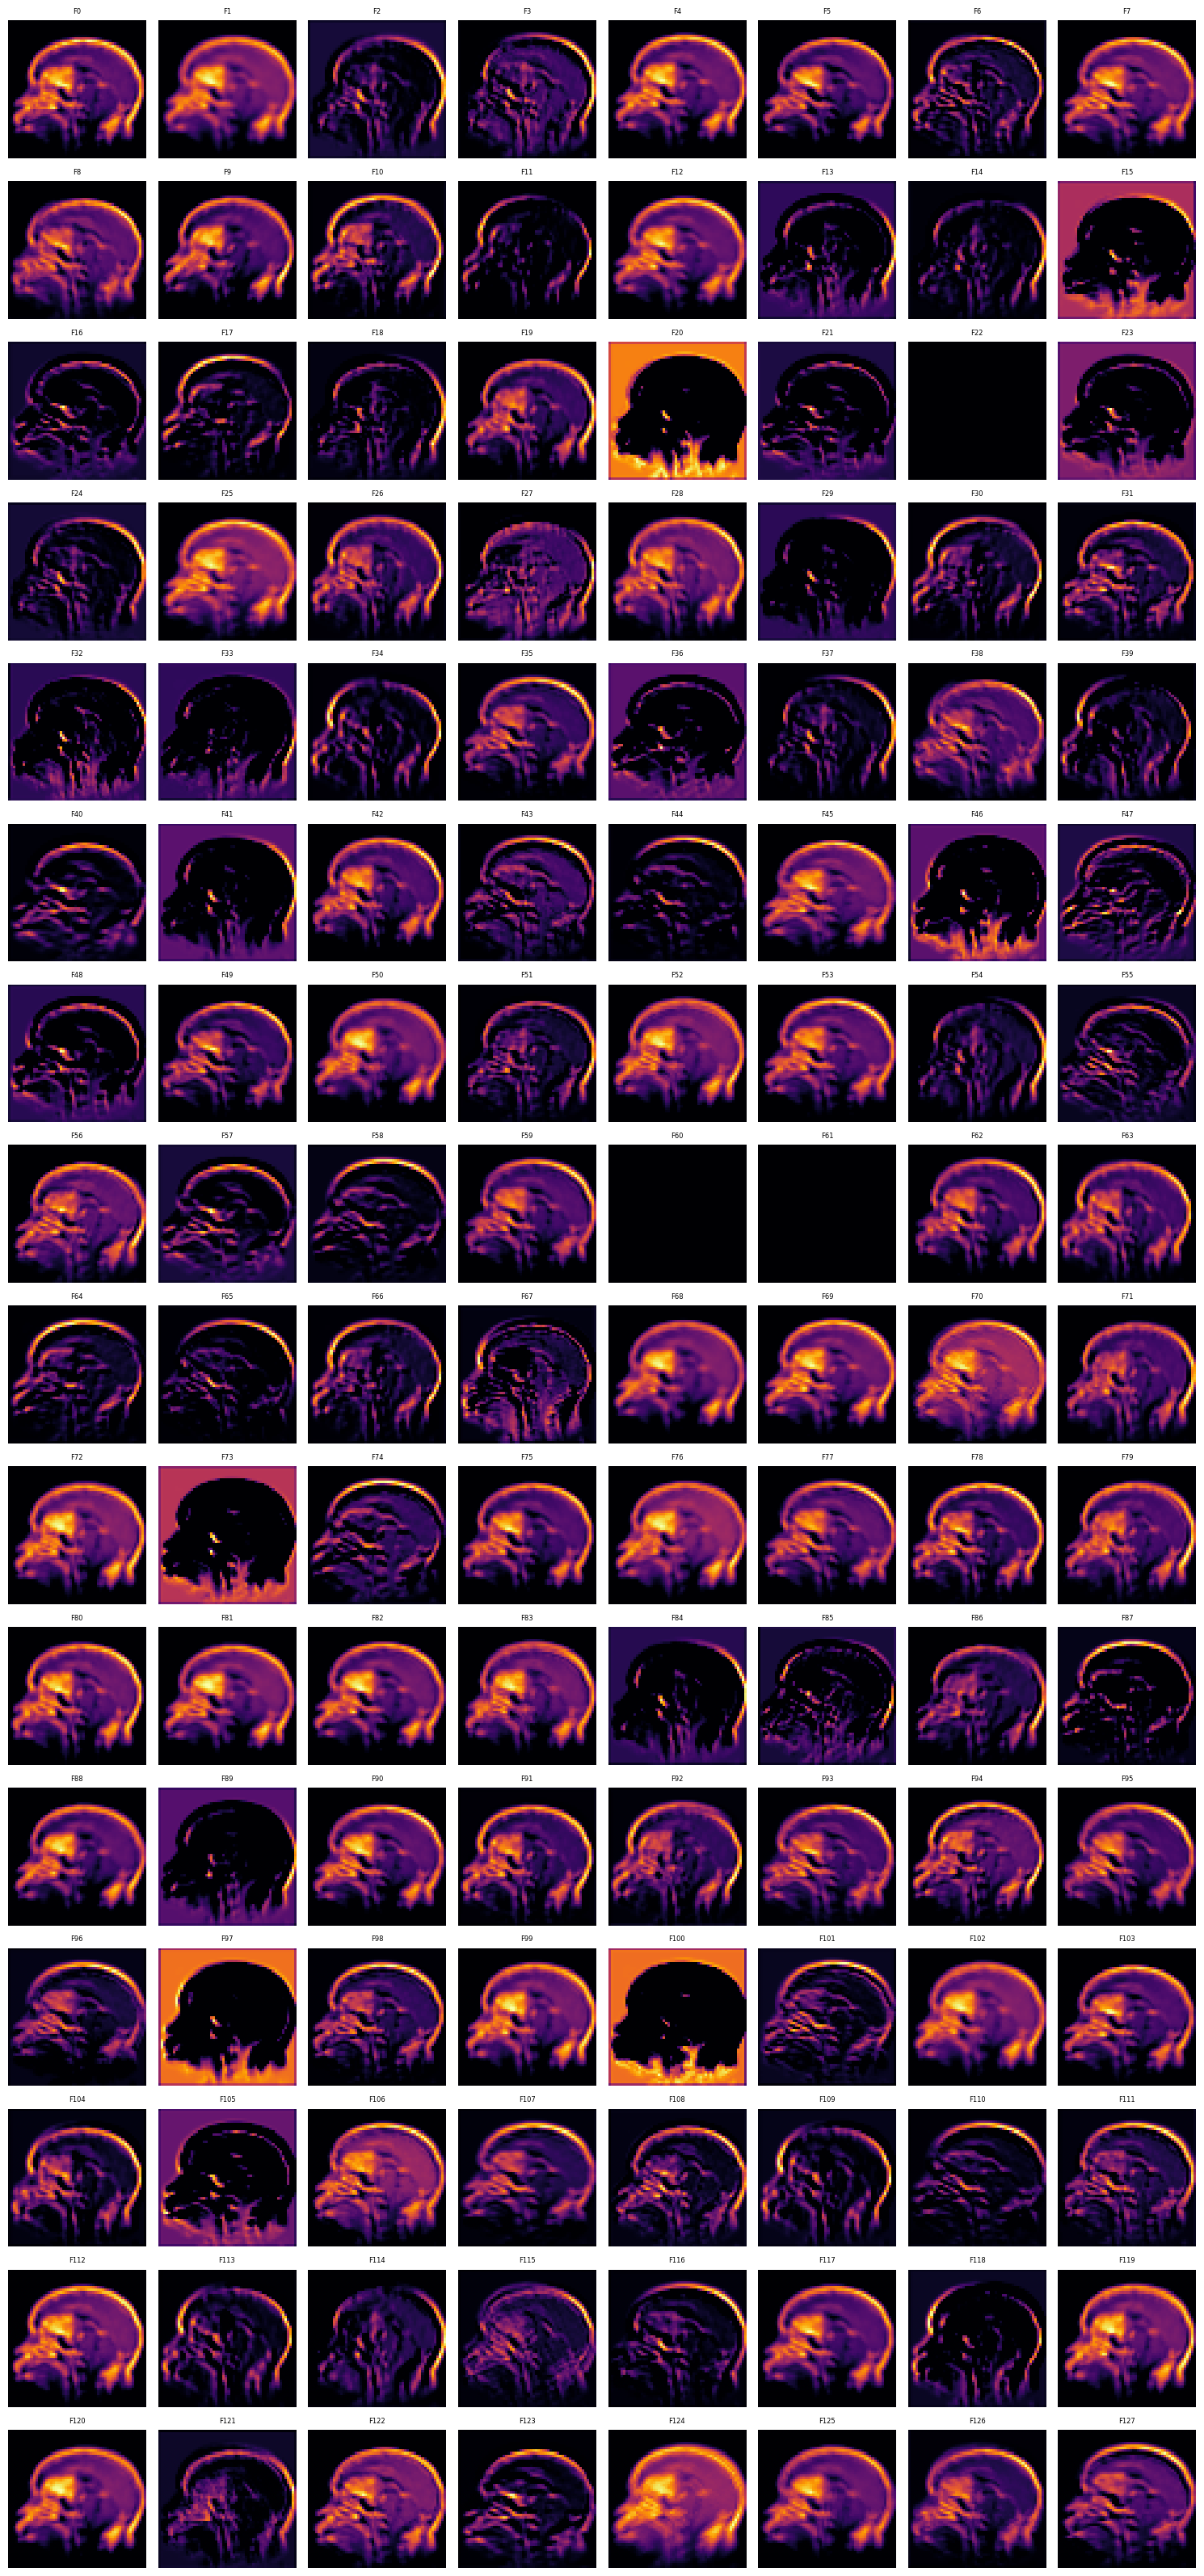

In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Get a single explainer image
model.eval()
explainer_image, explainer_label = next(iter(test_loader))
explainer_image = explainer_image[1]        # take first image in batch
explainer_label = explainer_label[1].item()

explainer_image_device = explainer_image.unsqueeze(0).to(device)

class_names = train_dataset.classes

# Show the explainer image
plt.figure(figsize=(4,4))
plt.imshow(explainer_image.permute(1, 2, 0))
plt.axis("off")
plt.title(f"Explainer Image\nTrue Label: {class_names[explainer_label]}")
plt.show()

print("Image dimensions:", explainer_image.shape)

#Model prediction

with torch.no_grad():
    output = model(explainer_image_device)
    _, pred_class = torch.max(output, 1)
    pred_class = pred_class.item()

print("Predicted Label:", class_names[pred_class])

plt.figure(figsize=(4,4))
plt.imshow(explainer_image.permute(1, 2, 0))
plt.axis("off")
plt.title(f"Prediction: {class_names[pred_class]}\nTrue: {class_names[explainer_label]}")
plt.show()


#  Extract last convolutional layer activations
feature_maps = model.feature_maps[0].detach().cpu()   # shape: (32, 28, 28)
print("Feature map size:", feature_maps.shape)

num_features = feature_maps.shape[0]
cols = 8
rows = int(np.ceil(num_features / cols))

plt.figure(figsize=(15, rows * 2))

for i in range(num_features):
    fmap = feature_maps[i]
    fmap = (fmap - fmap.min()) / (fmap.max() + 1e-6)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(fmap, cmap='inferno')
    plt.axis("off")
    plt.title(f"F{i}", fontsize=6)

plt.tight_layout()
plt.show()



In [56]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

def visualize_featuremap_gradient(model, image_tensor, k, class_index):
    """
    model: trained CNN (GradCAM_CNN)
    image_tensor: input image of shape (1, 3, 224, 224)
    k: index of feature map channel
    class_index: target class (int)
    """

    model.eval()
    image_tensor = image_tensor.to(device)
    image_tensor.requires_grad = True

    #  Forward pass
    outputs = model(image_tensor)
    logits = outputs[0]

    print("Logits (scores before softmax):")
    print(logits.detach().cpu().numpy())
    print(f"Logit for class {class_index}: {logits[class_index].item()}")

    score = logits[class_index]

    # retain gradient at feature maps
    model.feature_maps.retain_grad()

    #  Backprop
    model.zero_grad()
    score.backward(retain_graph=True)

    #  Extract feature map
    fmap = model.feature_maps[0, k].detach().cpu().numpy()

    # Extract gradient map
    grad = model.feature_maps.grad[0, k].detach().cpu().numpy()

    print(f"\nFeature map shape: {fmap.shape}")
    print(f"Gradient map shape: {grad.shape}")

    # Normalize feature map for display
    fmap_norm = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-6)


    grad_vis = grad  # keep original values for colorbar

    # Normalize for creating overlay only
    grad_norm = (grad - grad.min()) / (grad.max() - grad.min() + 1e-6)

    heatmap = plt.cm.jet(grad_norm)[..., :3]
    overlay = 0.5 * heatmap + 0.5 * np.stack([fmap_norm]*3, axis=-1)

    # Plot everything
    fig, ax = plt.subplots(1, 3, figsize=(16, 5))

    # Feature map
    ax[0].imshow(fmap_norm, cmap="gray")
    ax[0].set_title(f"Feature Map k={k}")
    ax[0].axis("off")

    #  Gradient map
    im_grad = ax[1].imshow(grad_vis, cmap="jet")
    ax[1].set_title(f"Gradient ∂y_c/∂A^k for class {class_index}")
    ax[1].axis("off")

    # Add colourbar underneath gradient map
    cbar1 = fig.colorbar(im_grad, ax=ax[1], fraction=0.046, pad=0.04)
    cbar1.set_label("Gradient value\n(negative → decreases score,\npositive → increases score)", fontsize=8)

    # Overlay
    im_overlay = ax[2].imshow(overlay)
    ax[2].set_title("Overlay (gradient × feature map)")
    ax[2].axis("off")

    # Add colourbar underneath overlay (same gradient scale)
    cbar2 = fig.colorbar(im_grad, ax=ax[2], fraction=0.046, pad=0.04)
    cbar2.set_label("Gradient influence on feature map", fontsize=8)

    plt.show()

    return logits.detach(), fmap, grad



Logits (scores before softmax):
[ -4.508409    6.3053064  11.024708  -34.482815 ]
Logit for class 2: 11.024707794189453

Feature map shape: (56, 56)
Gradient map shape: (56, 56)


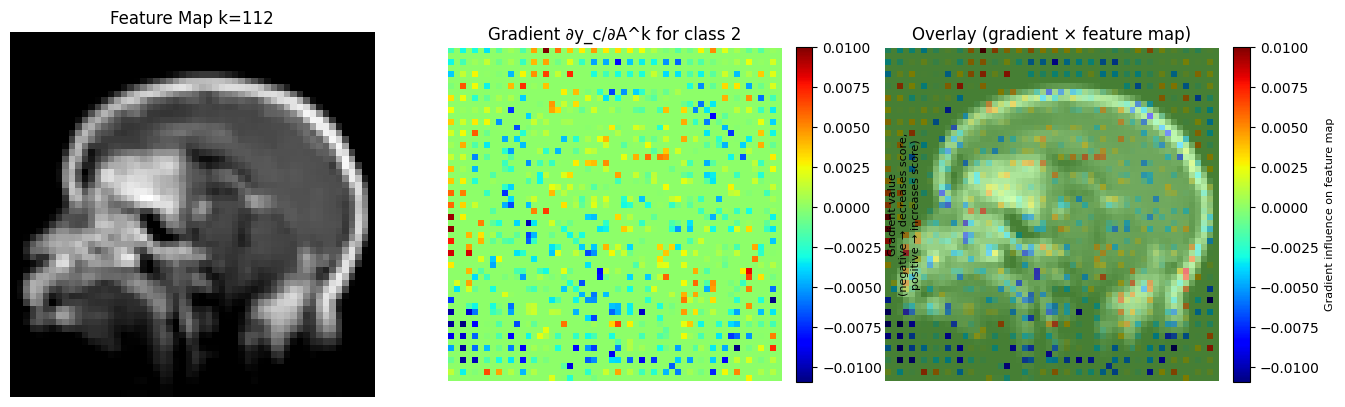

In [57]:
image = explainer_image.unsqueeze(0)
k = 112
c = 2

logits, fmap, grad = visualize_featuremap_gradient(model, image, k, c)

In [29]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def rank_channel_importance(model, image_tensor, class_index, top_n=5):
    """
    Computes channel importance α_k, ranks channels, visualizes top-n,
    and returns the combined weighted feature map before ReLU.
    """

    model.eval()
    image_tensor = image_tensor.to(device)
    image_tensor.requires_grad = True

    # Forward pass
    output = model(image_tensor)
    logits = output[0]
    print("Logits:", logits.detach().cpu().numpy())

    score = logits[class_index]

    # Retain gradient for intermediate feature maps
    model.feature_maps.retain_grad()

    # Backprop for class score
    model.zero_grad()
    score.backward(retain_graph=True)

    # Extract feature maps A^k and gradients dS/dA^k
    fmap = model.feature_maps.detach().cpu()[0]      # shape (C,H,W)
    grad = model.feature_maps.grad.detach().cpu()[0] # shape (C,H,W)

    C, H, W = fmap.shape

    # Compute α_k importance for each channel
    alpha = grad.view(C, -1).mean(dim=1)   # mean gradient per channel
    alpha_np = alpha.numpy()

    # Rank channels by absolute importance
    sorted_idx = np.argsort(-np.abs(alpha_np))

    print("\nTop-n important channels (ranked by |αₖ|):")
    for i in range(top_n):
        k = sorted_idx[i]
        print(f"Rank {i+1}: Channel {k} | weight α_k = {alpha_np[k]:.4f}")

    # PLOT TOP-N IMPORTANT CHANNELS
    fig, axs = plt.subplots(top_n, 3, figsize=(10, 3*top_n))
    if top_n == 1:
        axs = np.expand_dims(axs, 0)

    for rank in range(top_n):
        k = sorted_idx[rank]

        fmap_k = fmap[k].numpy()
        grad_k = grad[k].numpy()

        # Normalize for visualization
        fmap_norm = (fmap_k - fmap_k.min()) / (fmap_k.max() - fmap_k.min() + 1e-6)
        grad_norm = (grad_k - grad_k.min()) / (grad_k.max() - grad_k.min() + 1e-6)

        axs[rank, 0].imshow(fmap_norm, cmap='gray')
        axs[rank, 0].set_title(f"Feature Map k={k}")
        axs[rank, 0].axis("off")

        im1 = axs[rank, 1].imshow(grad_norm, cmap='jet')
        axs[rank, 1].set_title(f"Gradient Map k={k}\nα={alpha_np[k]:.4f}")
        axs[rank, 1].axis("off")

        # Weighted feature map α_k * A^k
        weighted = alpha_np[k] * fmap_k
        weighted_norm = (weighted - weighted.min()) / (weighted.max() - weighted.min() + 1e-6)

        axs[rank, 2].imshow(weighted_norm, cmap='inferno')
        axs[rank, 2].set_title("αₖ A^k")
        axs[rank, 2].axis("off")

    plt.tight_layout()
    plt.show()

    #Compute Combined Weighted Feature Map (pre-ReLU CAM)
    weighted_sum = (alpha_np.reshape(-1,1,1) * fmap.numpy()).sum(axis=0)

    # Normalize for display
    weighted_sum_norm = (weighted_sum - weighted_sum.min()) / (weighted_sum.max() - weighted_sum.min() + 1e-6)

    # Plot CAM before ReLU
    plt.figure(figsize=(5,5))
    plt.imshow(weighted_sum_norm, cmap="inferno")
    plt.title("Linearly Combined Weighted Feature Map\n(CAM Pre-ReLU)")
    plt.axis("off")
    plt.colorbar()
    plt.show()

    # Return values
    return {
        "alpha": alpha_np,
        "importance_order": sorted_idx,
        "fmap": fmap.numpy(),
        "grad": grad.numpy(),
        "cam_pre_relu": weighted_sum,
    }


Logits: [ -4.508409    6.3053064  11.024708  -34.482815 ]

Top-n important channels (ranked by |αₖ|):
Rank 1: Channel 97 | weight α_k = 0.0012
Rank 2: Channel 114 | weight α_k = 0.0009
Rank 3: Channel 41 | weight α_k = 0.0007
Rank 4: Channel 27 | weight α_k = 0.0006
Rank 5: Channel 74 | weight α_k = 0.0006


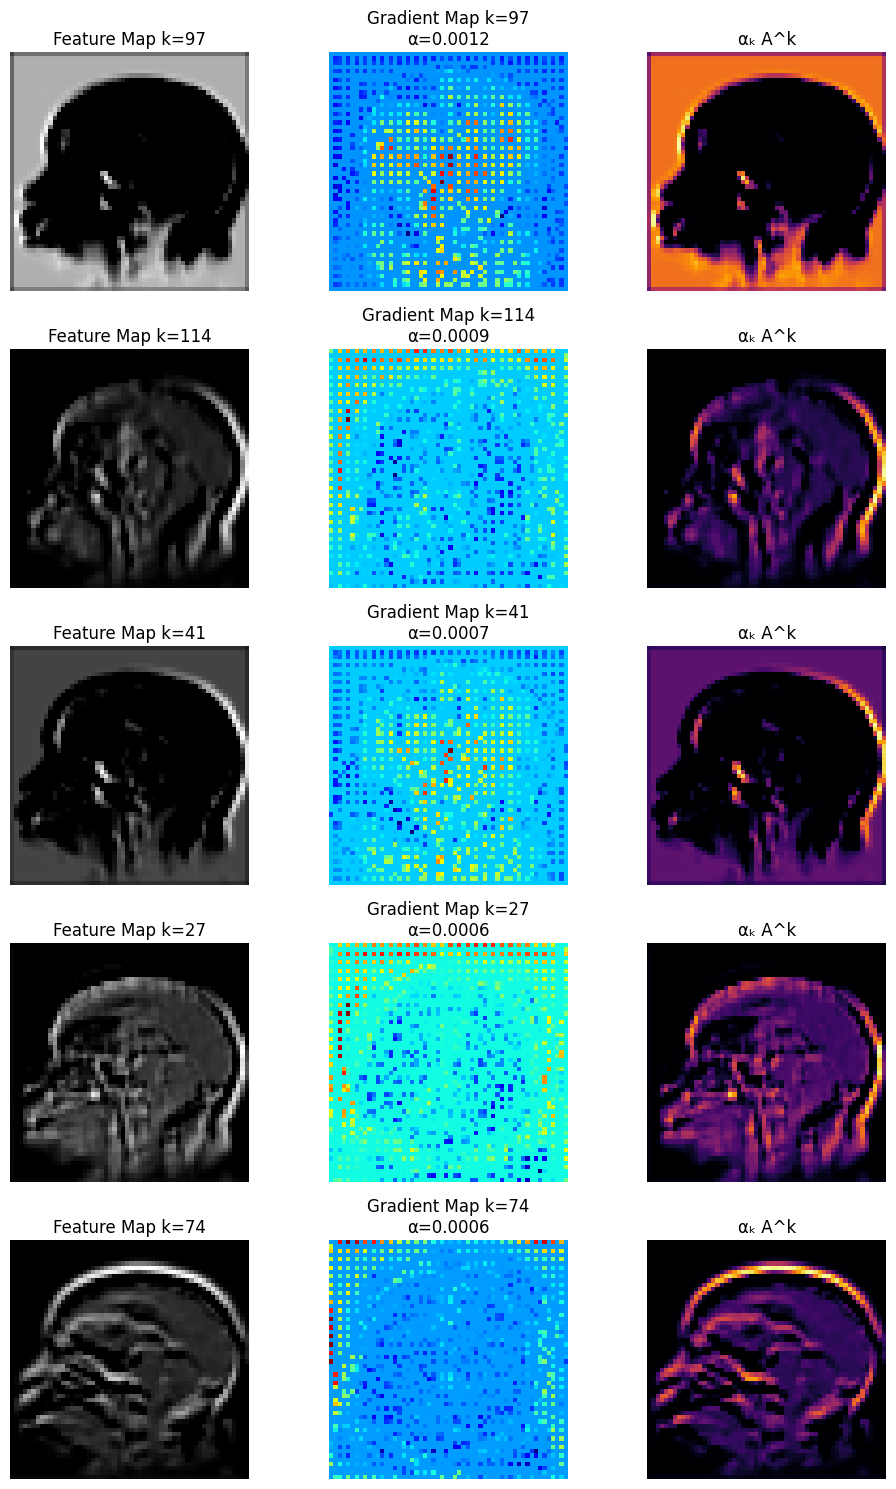

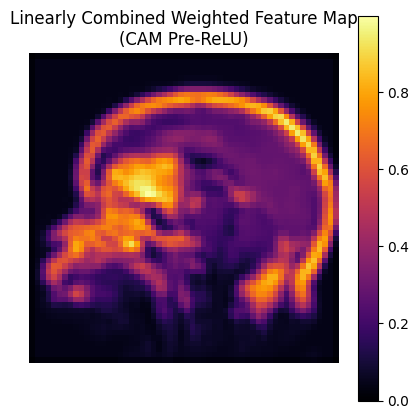

In [38]:
image = explainer_image.unsqueeze(0)   # (1,3,224,224)
class_index = 2
top_n = 5

results = rank_channel_importance(model, image, class_index, top_n)


In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F


def compute_and_overlay_CAM(model, image_tensor, class_index):
    """
    Computes pre-ReLU and post-ReLU CAM, downsamples MRI to feature map size,
    and overlays CAMs on the downsampled MRI.
    """

    model.eval()
    image_tensor = image_tensor.to(device)
    image_tensor.requires_grad = True

    # Forward pass
    output = model(image_tensor)
    logits = output[0]
    score = logits[class_index]

    # Retain feature map gradients
    model.feature_maps.retain_grad()

    # Backprop
    model.zero_grad()
    score.backward(retain_graph=True)

    fmap = model.feature_maps.detach().cpu()[0]          # (C,H,W)
    grad = model.feature_maps.grad.detach().cpu()[0]     # (C,H,W)

    C, H, W = fmap.shape

    # Compute alpha_k
    alpha = grad.view(C, -1).mean(dim=1).numpy()     # (C,)

    # Compute CAM_preReLU
    fmap_np = fmap.numpy()
    cam_pre = (alpha.reshape(-1, 1, 1) * fmap_np).sum(axis=0)   # (H,W)

    # Compute CAM_postReLU
    cam_post = np.maximum(cam_pre, 0)

    #  Downsample original MRI to the same size (H×W)
    mri = image_tensor[0].detach().cpu().numpy().transpose(1, 2, 0)  # (H_orig,W_orig,3)
    mri_torch = image_tensor.clone()

    # Resize to (1,3,H,W)
    mri_down = F.interpolate(mri_torch, size=(H, W), mode='bilinear', align_corners=False)
    mri_down = mri_down[0].detach().cpu().numpy().transpose(1, 2, 0)  # (H,W,3)

    # Normalize for visualization
    mri_down_norm = (mri_down - mri_down.min()) / (mri_down.max() - mri_down.min() + 1e-6)

    #Normalize CAMs for visualization
    def normalize(x):
        return (x - x.min()) / (x.max() - x.min() + 1e-6)

    cam_pre_norm = normalize(cam_pre)
    cam_post_norm = normalize(cam_post)

    heat_pre = plt.cm.jet(cam_pre_norm)[..., :3]
    heat_post = plt.cm.jet(cam_post_norm)[..., :3]

    overlay_pre = 0.6 * heat_pre + 0.4 * mri_down_norm
    overlay_post = 0.6 * heat_post + 0.4 * mri_down_norm

    # ---- 8. Plot results ----
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))

    # Downsampled MRI
    ax[0, 0].imshow(mri_down_norm)
    ax[0, 0].set_title("Downsampled MRI (28×28)")
    ax[0, 0].axis("off")

    # Pre-ReLU CAM (raw)
    ax[0, 1].imshow(cam_pre_norm, cmap='jet')
    ax[0, 1].set_title("CAM Pre-ReLU")
    ax[0, 1].axis("off")
    fig.colorbar(ax[0, 1].images[0], ax=ax[0, 1], fraction=0.046, pad=0.04)

    # Overlay Pre-ReLU CAM
    ax[0, 2].imshow(overlay_pre)
    ax[0, 2].set_title("Overlay: Pre-ReLU CAM")
    ax[0, 2].axis("off")

    # Post-ReLU CAM
    ax[1, 1].imshow(cam_post_norm, cmap='jet')
    ax[1, 1].set_title("CAM Post-ReLU")
    ax[1, 1].axis("off")
    fig.colorbar(ax[1, 1].images[0], ax=ax[1, 1], fraction=0.046, pad=0.04)

    # Overlay Post-ReLU CAM
    ax[1, 2].imshow(overlay_post)
    ax[1, 2].set_title("Overlay: Post-ReLU CAM")
    ax[1, 2].axis("off")

    # Hide empty subplot
    ax[1, 0].axis("off")

    plt.tight_layout()
    plt.show()

    return {
        "cam_pre": cam_pre,
        "cam_post": cam_post,
        "cam_pre_overlay": overlay_pre,
        "cam_post_overlay": overlay_post,
        "alpha": alpha
    }


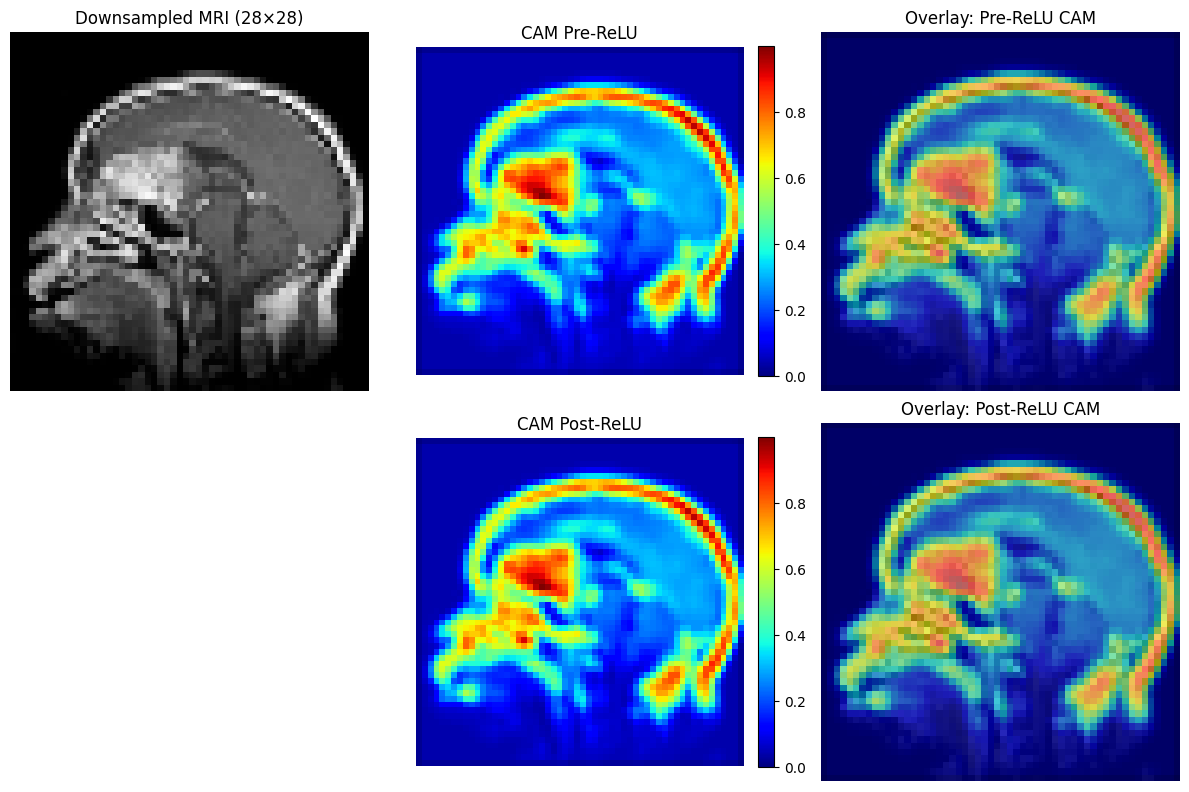

In [33]:
image = explainer_image.unsqueeze(0)   # (1,3,224,224)
c = 2

results = compute_and_overlay_CAM(model, image, c)


In [36]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np


def upsample_and_overlay_CAM(model, image_tensor, cam_post):
    """
    Upsamples a post-ReLU CAM using bilinear interpolation
    and overlays it on the full-resolution MRI image.
    """

    # Original image (1,3,224,224)
    image_tensor = image_tensor.to(device)

    # Convert post-relu CAM (H,W) → torch tensor (1,1,H,W)
    cam_post_t = torch.tensor(cam_post, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    # Upsample to match the MRI resolution using bilinear interpolation
    upsampled = F.interpolate(cam_post_t, size=image_tensor.shape[-2:], mode='bilinear', align_corners=False)

    upsampled_cam = upsampled[0, 0].detach().cpu().numpy()

    # Normalize for visualization
    cam_up_norm = (upsampled_cam - upsampled_cam.min()) / (upsampled_cam.max() - upsampled_cam.min() + 1e-6)

    # Prepare original MRI for visualization
    mri = image_tensor[0].detach().cpu().numpy().transpose(1, 2, 0)
    mri_norm = (mri - mri.min()) / (mri.max() - mri.min() + 1e-6)

    # Create heatmap overlay
    heat = plt.cm.jet(cam_up_norm)[..., :3]
    overlay = 0.6 * heat + 0.4 * mri_norm

    # ---- Plot results ----
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Original post-ReLU CAM (28×28)
    ax[0].imshow(cam_post, cmap='jet')
    ax[0].set_title("Original Post-ReLU CAM (28×28)")
    ax[0].axis("off")

    # Upsampled CAM (224×224)
    ax[1].imshow(cam_up_norm, cmap='jet')
    ax[1].set_title("Upsampled CAM (Bilinear, 224×224)")
    ax[1].axis("off")

    # Overlay
    ax[2].imshow(overlay)
    ax[2].set_title("Overlay: Upsampled CAM + MRI")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()

    return cam_up_norm, overlay


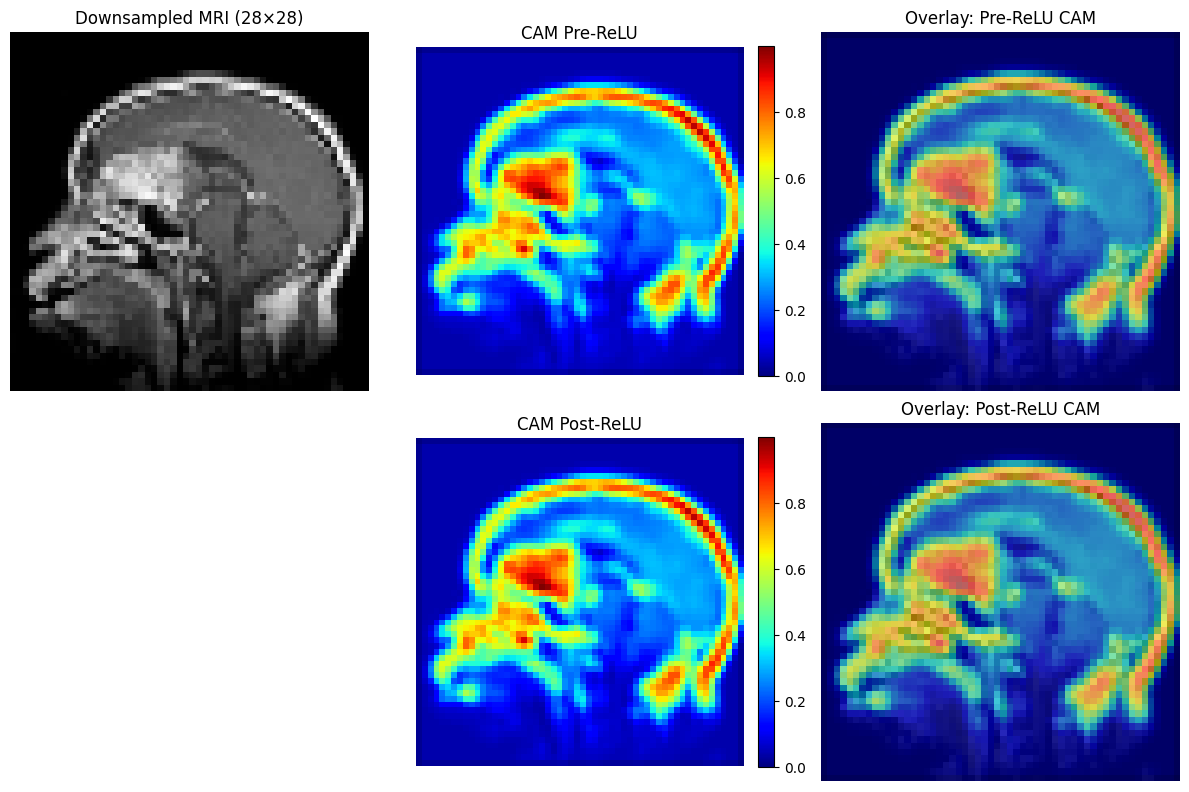

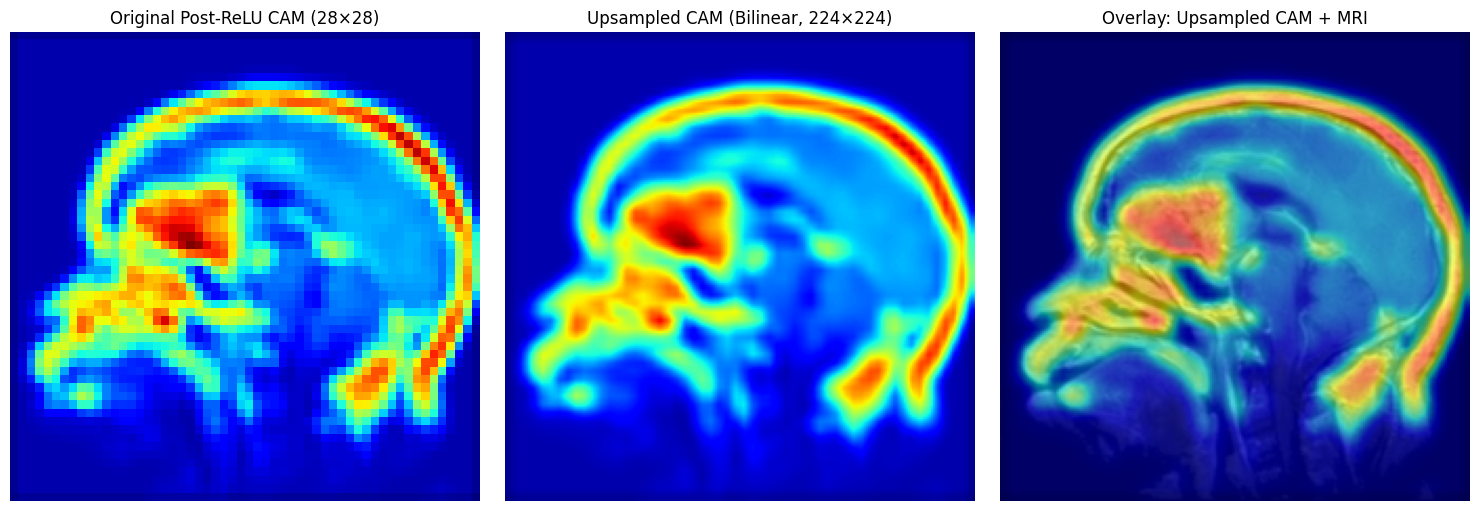

In [37]:
class_index = 2
image = explainer_image.unsqueeze(0)

results = compute_and_overlay_CAM(model, image, class_index)

cam_post = results["cam_post"]    # 28×28 post-ReLU CAM

cam_up, overlay = upsample_and_overlay_CAM(model, image, cam_post)


In [35]:
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=ec0e5aac56bc0f196e515b8a69b2f7d3cc325b49a337e37066195f483d02a6d2
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [49]:

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


target_layer = model.conv3


cam = GradCAM(model=model,
              target_layers=[target_layer])


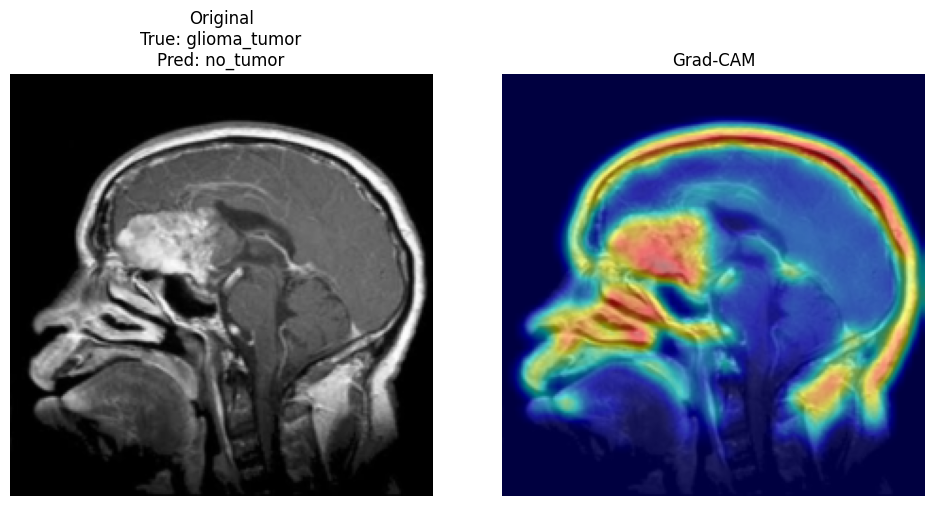

In [52]:
import cv2

# Get explainer imaage from test set

model.eval()
images, labels = next(iter(test_loader))

image = images[1].to(device)         # shape (3,224,224)
label = labels[1]


# Make prediction
with torch.no_grad():
    output = model(image.unsqueeze(0))
    _, pred = torch.max(output, 1)


# Create GradCAM heatmap
input_tensor = image.unsqueeze(0)  # shape (1,3,224,224)
target = [ClassifierOutputTarget(pred.item())]

grayscale_cam = cam(input_tensor=input_tensor, targets=target)[0]

# Convert tensor image → numpy RGB image (0-1)
img = images[1].permute(1, 2, 0).cpu().numpy()
img = np.clip(img, 0, 1)

# Ensure CAM is numpy float32
grayscale_cam = grayscale_cam.astype(np.float32)

# Overlay
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)


# Plot GradCAM visualization

class_names = train_dataset.classes
true_label = class_names[label.item()]
pred_label = class_names[pred.item()]

plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title(f"Original\nTrue: {true_label}\nPred: {pred_label}")

# Heatmap
plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.axis('off')
plt.title("Grad-CAM")

plt.tight_layout()
plt.show()


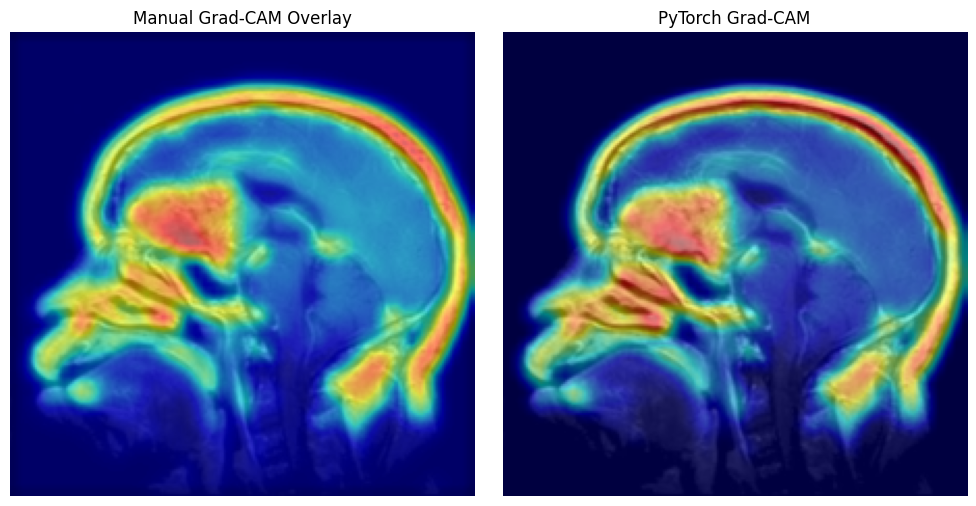

In [53]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(overlay)
plt.title("Manual Grad-CAM Overlay")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title("PyTorch Grad-CAM")
plt.axis("off")

plt.tight_layout()
plt.show()
